IoU matrix:
 [[0.529 0.    0.415 0.076 0.   ]
 [0.    0.828 0.    0.129 0.   ]
 [0.132 0.    0.586 0.    0.   ]
 [0.181 0.094 0.    0.792 0.   ]
 [0.015 0.    0.    0.    0.713]]

Matches (orig_idx -> new_idx, IoU ≥ 0.5):
0 -> 0, IoU = 0.529
1 -> 1, IoU = 0.828
2 -> 2, IoU = 0.586
3 -> 3, IoU = 0.792
4 -> 4, IoU = 0.713


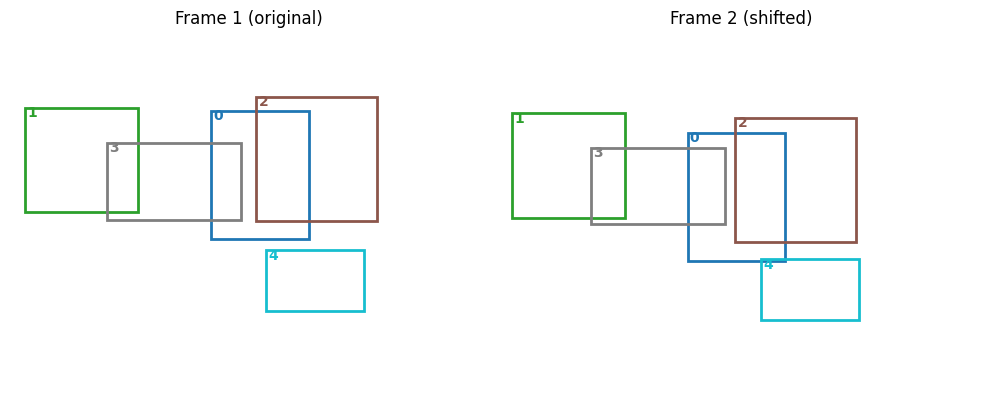

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import itertools
def linear_sum_assignment(cost_matrix):
    n_rows, n_cols = cost_matrix.shape
    assert n_rows == n_cols
    best_cost = math.inf
    best_perm = None
    for perm in itertools.permutations(range(n_cols)):
        c = sum(cost_matrix[i, perm[i]] for i in range(n_rows))
        if c < best_cost:
            best_cost = c
            best_perm = perm
    row_ind = np.arange(n_rows)
    col_ind = np.array(best_perm)
    return row_ind, col_ind


def gen_random_boxes(n, img_w, img_h, min_size=80, max_size=180):
    """Случайные рамки (x1, y1, x2, y2)."""
    boxes = []
    for _ in range(n):
        w = np.random.randint(min_size, max_size)
        h = np.random.randint(min_size, max_size)
        x1 = np.random.randint(0, img_w - w)
        y1 = np.random.randint(0, img_h - h)
        x2 = x1 + w
        y2 = y1 + h
        boxes.append([x1, y1, x2, y2])
    return np.array(boxes, dtype=np.float32)


def iou(box_a, box_b):
    """IoU двух рамок."""
    x1 = max(box_a[0], box_b[0])
    y1 = max(box_a[1], box_b[1])
    x2 = min(box_a[2], box_b[2])
    y2 = min(box_a[3], box_b[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h
    if inter <= 0:
        return 0.0

    area_a = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    area_b = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    union = area_a + area_b - inter
    if union <= 0:
        return 0.0

    return float(inter / union)


def iou_matrix(boxes1, boxes2):
    """Матрица IoU (n1 x n2)."""
    n1, n2 = len(boxes1), len(boxes2)
    m = np.zeros((n1, n2), dtype=np.float32)
    for i in range(n1):
        for j in range(n2):
            m[i, j] = iou(boxes1[i], boxes2[j])
    return m


def perturb_boxes(boxes, img_w=640, img_h=480, frac_shift=0.18):
    """
    Один случайный сдвиг рамок.
    Сдвиг по каждой оси ≤ frac_shift*размер рамки → IoU(старый, новый) ≳ 0.5.
    """
    new_boxes = []
    for (x1, y1, x2, y2) in boxes:
        w = x2 - x1
        h = y2 - y1

        max_dx = max(1, int(frac_shift * w))
        max_dy = max(1, int(frac_shift * h))

        dx = np.random.randint(-max_dx, max_dx + 1)
        dy = np.random.randint(-max_dy, max_dy + 1)

        nx1 = x1 + dx
        ny1 = y1 + dy

        # следим, чтобы бокс не вылез за границу и сохранил размер
        nx1 = np.clip(nx1, 0, img_w - w)
        ny1 = np.clip(ny1, 0, img_h - h)
        nx2 = nx1 + w
        ny2 = ny1 + h

        new_boxes.append([nx1, ny1, nx2, ny2])

    return np.array(new_boxes, dtype=np.float32)


def match_boxes_hungarian(boxes1, boxes2, iou_threshold=0.5):
    """Матчинг по венгерскому: максимизируем IoU (минимизируем 1 - IoU)."""
    ious = iou_matrix(boxes1, boxes2)
    cost = 1.0 - ious
    row_ind, col_ind = linear_sum_assignment(cost)

    matches = []
    for r, c in zip(row_ind, col_ind):
        if ious[r, c] >= iou_threshold:
            matches.append((r, c, ious[r, c]))
    return matches, ious


def draw_frames(boxes1, boxes2, matches, img_w=640, img_h=480):
    """Рисуем 2 кадра и подписи ID."""
    n1 = len(boxes1)
    n2 = len(boxes2)

    colors = plt.cm.tab10(np.linspace(0, 1, max(n1, n2)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title("Frame 1 (original)")
    ax2.set_title("Frame 2 (shifted)")

    for ax in (ax1, ax2):
        ax.set_xlim(0, img_w)
        ax.set_ylim(img_h, 0)  # (0,0) сверху слева
        ax.set_aspect("equal")
        ax.axis("off")

    # для каждого бокса второго кадра — ID исходного (или -1, если нет матча)
    id_for_new = [-1] * n2
    for r, c, _iou_val in matches:
        id_for_new[c] = r

    # левый кадр
    for i, (x1, y1, x2, y2) in enumerate(boxes1):
        w = x2 - x1
        h = y2 - y1
        rect = Rectangle((x1, y1), w, h, fill=False, linewidth=2,
                         edgecolor=colors[i])
        ax1.add_patch(rect)
        ax1.text(x1 + 3, y1 + 12, f"{i}", color=colors[i],
                 fontsize=10, fontweight="bold")

    # правый кадр
    for j, (x1, y1, x2, y2) in enumerate(boxes2):
        w = x2 - x1
        h = y2 - y1
        idx = id_for_new[j]
        color = colors[idx] if idx >= 0 else "black"
        rect = Rectangle((x1, y1), w, h, fill=False, linewidth=2,
                         edgecolor=color)
        ax2.add_patch(rect)

        label = str(idx) if idx >= 0 else "x"
        ax2.text(x1 + 3, y1 + 12, label, color=color,
                 fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.show()


def main():
    np.random.seed(42)

    IMG_W, IMG_H = 640, 480
    N = 5
    IOU_THR = 0.5

    boxes1 = gen_random_boxes(N, IMG_W, IMG_H)
    boxes2 = perturb_boxes(boxes1, img_w=IMG_W, img_h=IMG_H, frac_shift=0.18)

    matches, ious = match_boxes_hungarian(boxes1, boxes2, iou_threshold=IOU_THR)

    print("IoU matrix:\n", np.round(ious, 3))
    print("\nMatches (orig_idx -> new_idx, IoU ≥ 0.5):")
    for r, c, score in matches:
        print(f"{r} -> {c}, IoU = {score:.3f}")

    draw_frames(boxes1, boxes2, matches, img_w=IMG_W, img_h=IMG_H)


if __name__ == "__main__":
    main()
